## Australian Archibald Prize Analysis

The Archibald Prize is an annually awarded prestigious prize presented to the best protrait. It was first awarded in 1921 and has been awarded annually since then (but with two expentions).

Here, we will use Python to analyse the Archibald Prize dataset that was scraped from the Archibald website over the 97 years. We will analyse this dataset to get insights into the habits and qualities of the winning portraits, but also see what is common between the artworks that are submitted to the Archibald Prize.

For each of those years, the dataset contains data of the winning prize and the final contestants. While I attempted to scrape as much information about the artworks as possible, unfrotunetly the Archibald website does not contain the same degree of information of artworks from 1921 to 2002 as compared to 2003 and onwards.

From 1921 to 2002, the dataset contains a total of 179 artworks including 81 winning portraits. From 2003, the dataset contains a total of 752 portraits which includes 15 winning portraits.

Its important to note that altough in recent years two other prizes have also been adeded to the Archibald prize event, I am only concerned with the traditional Archinald Prize.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None

import warnings
from collections import Counter
import datetime
import wordcloud
import json

from dateutil.parser import parse
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [18]:
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["ytick.labelsize"] = 15
plt.rcParams["axes.labelsize"] = 15

### Scraping the Data - A few words
Web scraping as you may know is a way to automatically extract data and present it in a format (usually a table) you can make sense of and of course to analyse. For this dataset, I used the Python library known as BeautifulSoup. 

Since the focus of this article is to analyse the dataset, I have not include the code that I used to scrape the data.

In [2]:
df_one = pd.read_csv("input/dataset/archibald_prize_dataset_one.csv", encoding='ISO-8859-1')
df_two = pd.read_csv("input/dataset/archibald_prize_dataset_two.csv", encoding = "ISO-8859-1")
df = df_one.append(df_two)

In [3]:
print(df.shape)
df.info()
df.head(2)

(931, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 931 entries, 0 to 178
Data columns (total 14 columns):
artlink-href             931 non-null object
competition              931 non-null object
description              671 non-null object
dimensions               904 non-null object
item                     931 non-null object
item-href                931 non-null object
medium                   917 non-null object
name                     931 non-null object
prize                    127 non-null object
title                    931 non-null object
web-scraper-order        931 non-null object
web-scraper-start-url    931 non-null object
year-text                931 non-null object
year-text-href           931 non-null object
dtypes: object(14)
memory usage: 58.2+ KB


,artlink-href,competition,description,dimensions,item,item-href,medium,name,prize,title,web-scraper-order,web-scraper-start-url,year-text,year-text-href
0,https://media.artgallery.nsw.gov.au/prize_imag...,Archibald Prize 2017,"The subject of Anh Dos portrait, winner of th...",240 x 200 cm,Anh Do\n\n \t\tJC\n \nWinner: Pe...,https://www.artgallery.nsw.gov.au/prizes/archi...,"oil on linen with unicorn hologram, dead insec...",Anh Do,Winner: People's Choice 2017,JC,1538564648-692,https://www.artgallery.nsw.gov.au/prizes/archi...,Archibald 2017 finalists\n\t\t\n\t\t \n ...,https://www.artgallery.nsw.gov.au/prizes/archi...
1,https://media.artgallery.nsw.gov.au/prize_imag...,Archibald Prize 2013,Nicholas Jones is a Melbourne-based sculptor w...,91.5 x 76 cm,Julia Ciccarone\n\n \t\tPortrait of Nichola...,https://www.artgallery.nsw.gov.au/prizes/archi...,oil on linen,Julia Ciccarone,NaN,Portrait of Nicholas Jones,1538563617-489,https://www.artgallery.nsw.gov.au/prizes/archi...,Archibald 2013 finalists\n\t\t\n\t\t \n ...,https://www.artgallery.nsw.gov.au/prizes/archi...


Unfortunetly during the scraping, I found multiple duplicates in the data. This turns out to be true mostly for the winning artworks as they were linked twice in the sampe page (one at the top and the other amongst the other finalists).

As you can see in the table above, the winning artwoks are the only records that contain a value for the 'prize' column. As such to remove duplicated records in favour of the winning artworks, I first sort by the prize, drop any duplicates if the name of the artist and title of the artwork match, and then keep the first record.

In [4]:
df = df.sort_values(by='prize').drop_duplicates(subset=['name', 'title'], keep='first')
print(df.shape)

(851, 14)


This reduced our number of recrods to 851 records.

In [5]:
df["prize"] = df["prize"].fillna(value="")
df["dimensions"] = df["dimensions"].fillna(value="")

In [6]:
df[df["dimensions"].apply(lambda x: pd.isna(x))].head(3)

,artlink-href,competition,description,dimensions,item,item-href,medium,name,prize,title,web-scraper-order,web-scraper-start-url,year-text,year-text-href


In [7]:
def grab_year(s):
    return parse(s, fuzzy=True).year

In [8]:
df['year'] = df["competition"].apply(lambda x: grab_year(x))

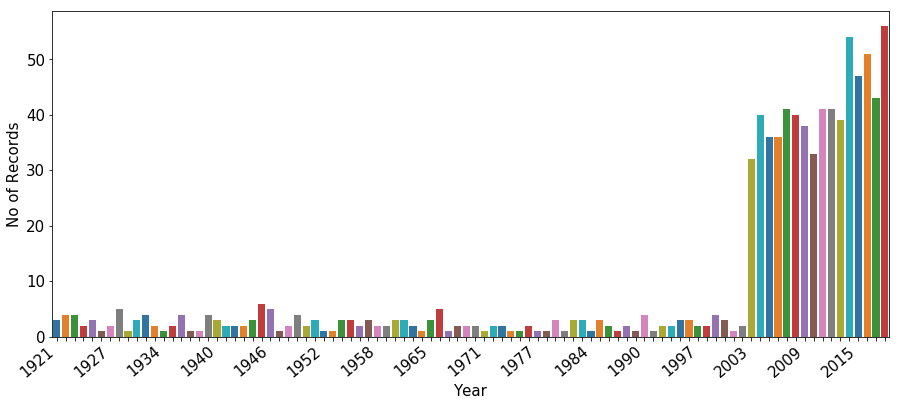

In [19]:
cdf = df["year"].value_counts().to_frame().reset_index().rename(columns={"index": "Year", "year": "No of Records"});
fig, ax = plt.subplots()
ax = sns.barplot(x="Year", y="No of Records", data=cdf, palette=sns.color_palette());
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 6 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

As stated before and as we can see form the table above, before 2003, there are only a handful of finalists data avaialible.

Zooming in...

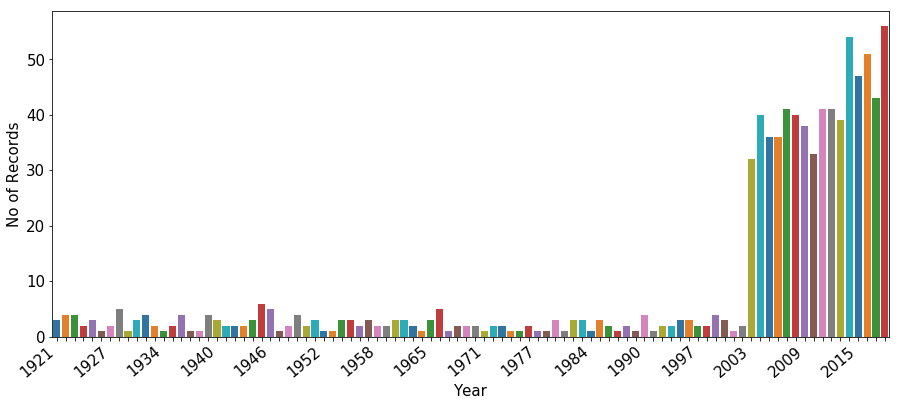

In [20]:
cdf = df["year"].value_counts().to_frame().reset_index().rename(columns={"index": "Year", "year": "No of Records"});
fig, ax = plt.subplots()
ax = sns.barplot(x="Year", y="No of Records", data=cdf, palette=sns.color_palette());
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 6 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [21]:
df['prize'] = df['prize'].replace("",np.nan)

In [22]:
df_winners = df[df['prize'].notnull()]
df_winners = df_winners[df_winners['prize'].str.contains("Archibald Prize", na=False, case=False)]
print(df_winners.shape)

(94, 17)


As you can see from the graph, before 2003, there is only a handful of finalists data avaialible.

It is also safe to say that the number of finalist has generally increased back from 2003.

In [23]:
def grab_dimensions(s):
    dimensions = re.findall(r"[-+]?\d*\.\d+|\d+", s)
    if len(dimensions) > 1:
        return pd.to_numeric(dimensions[0:2])
    else:
        return [0,0]

In [24]:
print(grab_dimensions("this is atest 123 2"))

[123   2]


In [25]:
df['height'] = df["dimensions"].apply(lambda x: grab_dimensions(x)[0]);
df['width'] = df["dimensions"].apply(lambda x: grab_dimensions(x)[1]);

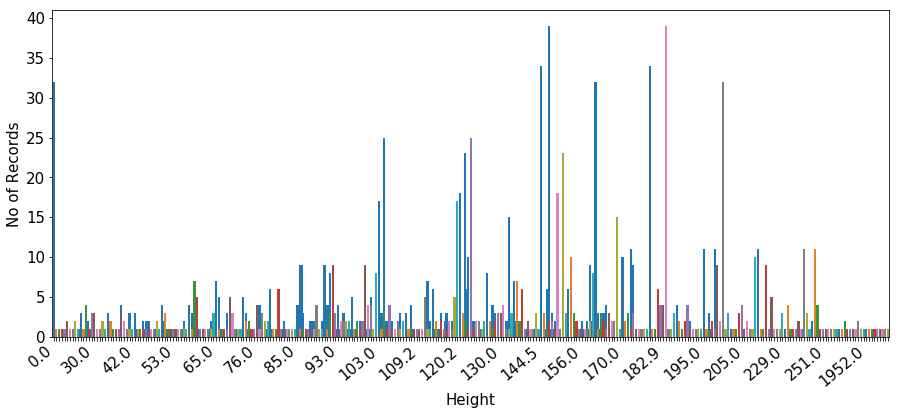

In [26]:
cdf = df["height"].value_counts().to_frame().reset_index().rename(columns={"index": "Height", "height": "No of Records"});
fig, ax = plt.subplots()
plt.bar(cdf['Height'],cdf['No of Records']);
ax = sns.barplot(x="Height", y="No of Records", data=cdf, palette=sns.color_palette());
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 15 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

In [27]:
df_winners = df[df['prize'].str.contains("Archibald Prize", na=False, case=False)]

In [28]:
bins = pd.Series(np.linspace(min(df_winners["width"]), max(df_winners["width"]), num=15).round(1))
df_winners['height_cut'] = pd.cut(df_winners["height"], bins=bins, include_lowest=True);
df_winners['width_cut'] = pd.cut(df_winners["width"], bins=bins, include_lowest=True);
df.describe()

,year,height,width
count,851.000000,851.000000,851.000000
mean,1999.826087,158.688014,147.982726
std,24.594649,204.556234,202.599246
min,1921.000000,0.000000,0.000000
25%,2003.000000,91.750000,78.200000
50%,2009.000000,150.000000,122.000000
75%,2014.000000,183.000000,178.000000
max,2018.000000,2011.000000,2011.000000


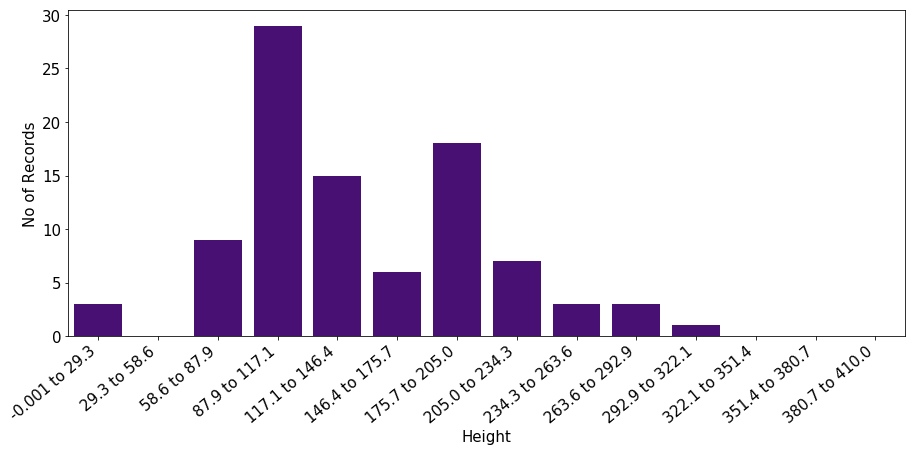

In [29]:
cdf_height = df_winners['height_cut'].value_counts(sort=False).to_frame().reset_index().rename(columns={"index": "Height", "height_cut": "No of Records"});
fig, ax = plt.subplots()
ax = sns.barplot(x="Height", y="No of Records", data=cdf_height, color = 'indigo');
ax.set_xticklabels(str(c).replace("(","").replace("]","").replace(","," to") for c in df_winners['height_cut'].cat.categories);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

As you can see, the 87.9 to 117.1cm range produced the most Archibald prize winners.

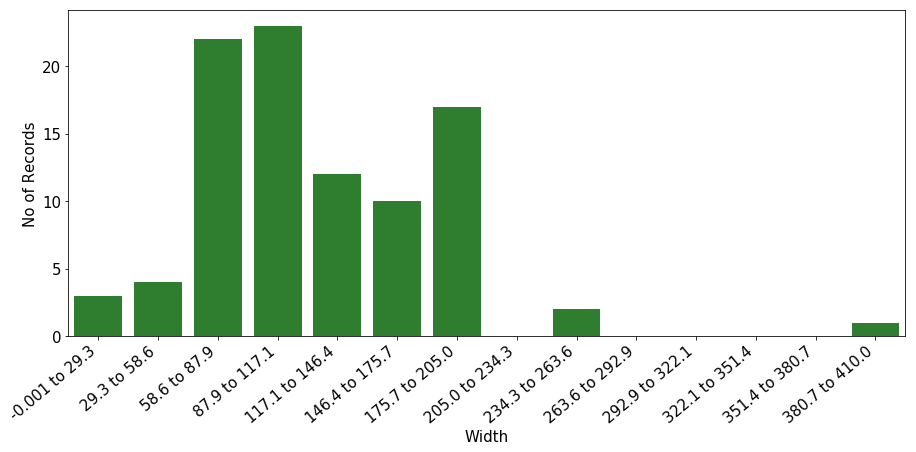

In [30]:
cdf_width = df_winners['width_cut'].value_counts(sort=False).to_frame().reset_index().rename(columns={"index": "Width", "width_cut": "No of Records"});
fig, ax = plt.subplots()
ax = sns.barplot(x="Width", y="No of Records", data=cdf_width, color = 'forestgreen');
ax.set_xticklabels(str(c).replace("(","").replace("]","").replace(","," to") for c in df_winners['height_cut'].cat.categories);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

As you can see, the 87.9 to 117.1cm range produced the most Archibald prize winners.

This tells me that most winning artworks are a square but not by a large margin.

[Text(0,0.5,'Width'), Text(0.5,0,'Height')]

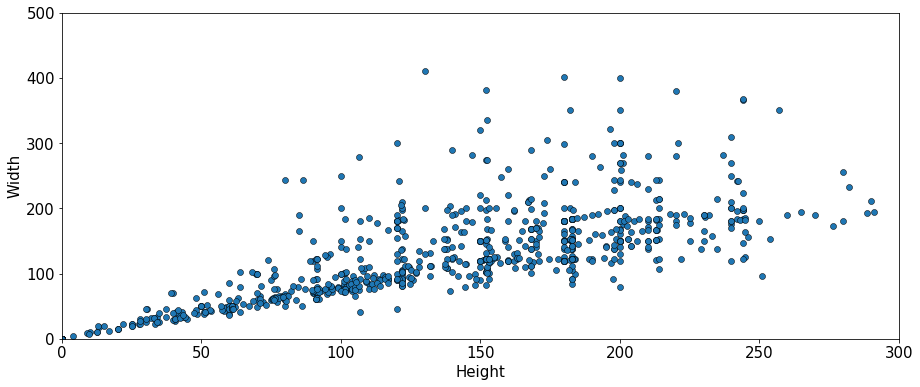

In [33]:
fig, ax = plt.subplots()
plt.scatter(x=df['height'], y=df['width'],edgecolors="#000000", linewidths=0.5)
plt.axis([0,300,0,500])
ax.set(xlabel="Height", ylabel="Width")

Plotting the Height and Width of the artworks, we can confirm that most artworks are actually porportionate values in height and width.

##### Note to self: Winning artwork dimensions be between 90-120cm in height and 90-120cm in width

Lets take a look at and analyse the type of mediums used by the contestants.

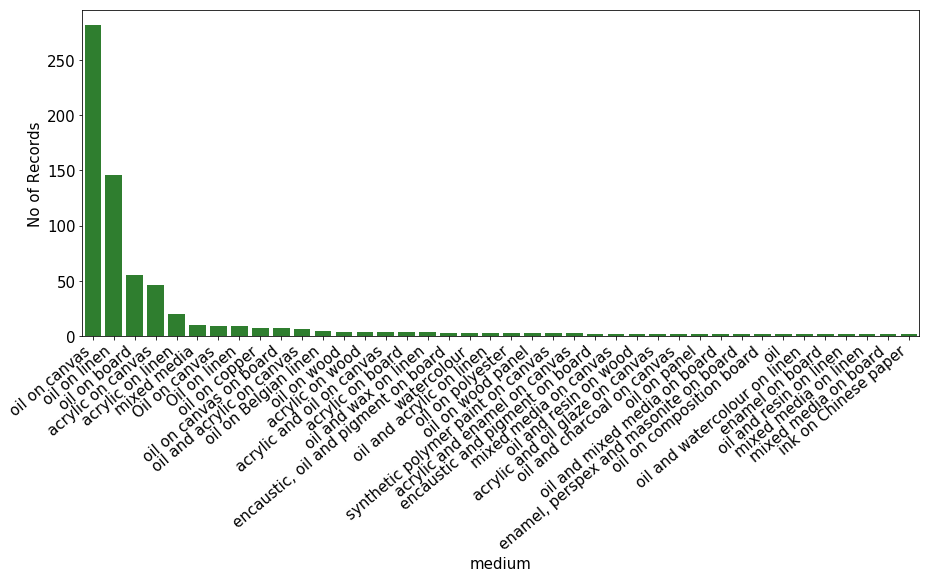

In [31]:
cdf = df["medium"].value_counts().to_frame().reset_index().rename(columns={"index": "medium", "medium": "No of Records"});
cdf = cdf[cdf["No of Records"]>1]
fig, ax = plt.subplots()
ax = sns.barplot(x="medium", y="No of Records", data=cdf, color = 'forestgreen');
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

What about the winning artworks?

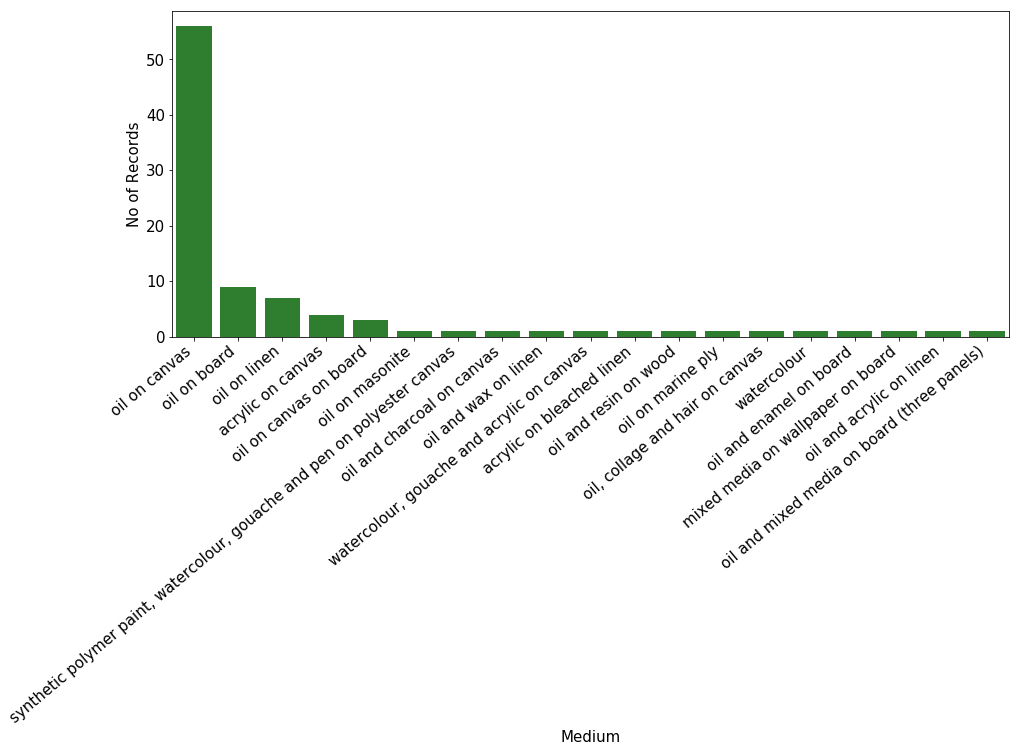

In [32]:
cdf = df_winners["medium"].value_counts().to_frame().reset_index().rename(columns={"index": "Medium", "medium": "No of Records"});
#cdf = cdf[cdf["No of Records"]>1]
fig, ax = plt.subplots()
ax = sns.barplot(x="Medium", y="No of Records", data=cdf, color = 'forestgreen');
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");



We note from the above graph that oil on canvas by far has a higher likelyhood of winning the prize

##### **Note to self: Use oil on canvas for artwork**



Lets look at the non-numerical columns

In [33]:
df.describe(include = ['O'])

,artlink-href,competition,description,dimensions,item,item-href,medium,name,prize,title,web-scraper-order,web-scraper-start-url,year-text,year-text-href
count,851,851,668,851,851,851,839,851,126,851,851,851,851,851
unique,851,94,668,723,851,851,205,407,126,808,851,1,94,94
top,https://media.artgallery.nsw.gov.au/prize_imag...,Archibald Prize 2018,Dane Taylor is the lead singer of the experime...,,"Belynda Henry\n\n \t\tLouise Olsen, a beaut...",https://www.artgallery.nsw.gov.au/prizes/archi...,oil on canvas,Jiawei Shen,Winner: Archibald Prize 1935,Self portrait,1538562729-279,https://www.artgallery.nsw.gov.au/prizes/archi...,Archibald 2018 finalists\n\t\t\n\t\t \n ...,https://www.artgallery.nsw.gov.au/prizes/archi...
freq,1,56,1,25,1,1,281,14,1,20,1,851,56,56


From the table, we can see that out of the 851 records, 668 artworks contains any descriptions.

### Simple Sentiment Analysis

**Note:** Before proceeding with this section, its important to note that I do not expect to get any useful predictions using the description of the artwork. I would be highly suprised if the description of the artwork plays a role in deciding the Archibald prize winner, but I think a simple sentiment analysis on the artwork descriptions would be fun to do. 

I would like to determine whether the description of the artworks has any correlation to the winning artwork.

There are of course quite alot of sophisticated methods to perform sentiment analysis, but for this (and as a start) I wanted to use the simplest method. Generally, I believe we should always start with the simplest possible solution before spending time doing potentially unnecessary modelling that underperforms.

As I stated in the beginning, I was only able to obtain the complete finalists from year 2003 and onwards. As such, to perform a fair and accurate sentiment analysis, I will only be using the data from 2003

16


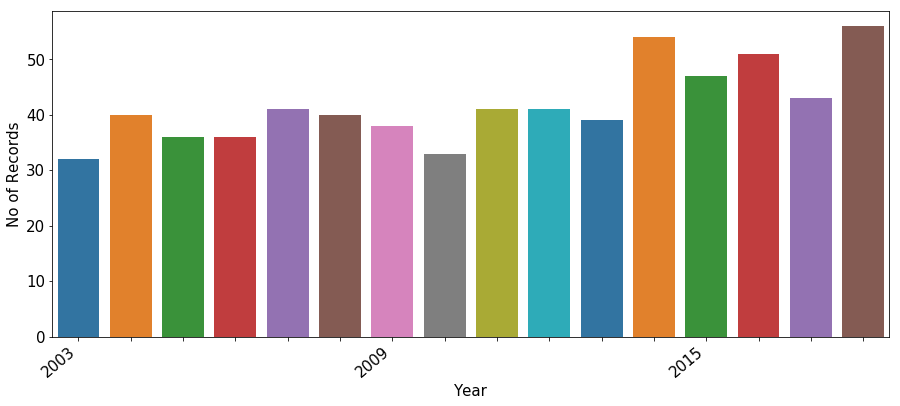

In [35]:
df_clean = df[df["year"]>=2003]
df_clean['archibald_winner'] = df_clean['prize'].str.contains("Archibald Prize", na=False, case=False)

print(np.sum(df_clean['archibald_winner']))

cdf = df_clean["year"].value_counts().to_frame().reset_index().rename(columns={"index": "Year", "year": "No of Records"});
fig, ax = plt.subplots()
plt.bar(cdf['Year'],cdf['No of Records']);
ax = sns.barplot(x="Year", y="No of Records", data=cdf, palette=sns.color_palette());
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

for ind, label in enumerate(ax.get_xticklabels()):
    if ind % 6 == 0:  # every 10th label is kept
        label.set_visible(True)
    else:
        label.set_visible(False)

Its important to note that in python True is 1 as False is 0. Because of this, we are able to perform any operations we want on the column by treating them as though they are numbers (because they are).

In [36]:
df_clean['description'] = df_clean['description'].str.lower()
df_clean['description_cleaned'] = df_clean['description'].replace("  ","")

In [43]:
# df_clean.to_csv('cleaned.csv')
df_clean.head()

,artlink-href,competition,description,dimensions,item,item-href,medium,name,prize,title,web-scraper-order,web-scraper-start-url,year-text,year-text-href,year,height,width,archibald_winner,description_cleaned
418,https://media.artgallery.nsw.gov.au/prize_imag...,Archibald Prize 2003,"predominantly a landscape painter, geoffrey dy...",183 x 152.5 cm,Geoffrey Dyer\n\n \t\tRichard F...,https://www.artgallery.nsw.gov.au/prizes/archi...,oil on linen,Geoffrey Dyer,Winner: Archibald Prize 2003,Richard Flanagan,1538562073-111,https://www.artgallery.nsw.gov.au/prizes/archi...,Archibald 2003 finalists\n\t\t\n\t\t \n ...,https://www.artgallery.nsw.gov.au/prizes/archi...,2003,183.0,152.5,True,"predominantly a landscape painter, geoffrey dy..."
177,https://media.artgallery.nsw.gov.au/prize_imag...,Archibald Prize 2004,gulpilil is one of australias leading aborigi...,204 x 240cm,Craig Ruddy\n\n \t\tDavid Gulpi...,https://www.artgallery.nsw.gov.au/prizes/archi...,mixed media on wallpaper on board,Craig Ruddy,Winner: Archibald Prize 2004\nWinner: People's...,"David Gulpilil, two worlds",1538562220-151,https://www.artgallery.nsw.gov.au/prizes/archi...,Archibald 2004 finalists\n\t\t\n\t\t \n ...,https://www.artgallery.nsw.gov.au/prizes/archi...,2004,204.0,240.0,True,gulpilil is one of australias leading aborigi...
502,https://media.artgallery.nsw.gov.au/prize_imag...,Archibald Prize 2005,john olsens artist statement about his archib...,182 x 200 cm,John Olsen\n\n \t\tSelf-portrai...,https://www.artgallery.nsw.gov.au/prizes/archi...,oil on canvas,John Olsen,Winner: Archibald Prize 2005,Self-portrait Janus-faced,1538562360-187,https://www.artgallery.nsw.gov.au/prizes/archi...,Archibald 2005 finalists\n\t\t\n\t\t \n ...,https://www.artgallery.nsw.gov.au/prizes/archi...,2005,182.0,200.0,True,john olsens artist statement about his archib...
87,https://media.artgallery.nsw.gov.au/prize_imag...,Archibald Prize 2006,marcus wills painting the paul juraszek monol...,265 x 195cm,Marcus Wills\n\n \t\tThe Paul J...,https://www.artgallery.nsw.gov.au/prizes/archi...,oil on linen,Marcus Wills,Winner: Archibald Prize 2006,The Paul Juraszek monolith (after Marcus Gheer...,1538562509-223,https://www.artgallery.nsw.gov.au/prizes/archi...,Archibald 2006 finalists\n\t\t\n\t\t \n ...,https://www.artgallery.nsw.gov.au/prizes/archi...,2006,265.0,195.0,True,marcus wills painting the paul juraszek monol...
248,https://media.artgallery.nsw.gov.au/prize_imag...,Archibald Prize 2007,janet laurence is an installation artist whose...,180 x 180 cm,John Beard\n\n \t\tJanet Lauren...,https://www.artgallery.nsw.gov.au/prizes/archi...,oil and wax on linen,John Beard,Winner: Archibald Prize 2007,Janet Laurence,1538562674-264,https://www.artgallery.nsw.gov.au/prizes/archi...,Archibald 2007 finalists\n\t\t\n\t\t \n ...,https://www.artgallery.nsw.gov.au/prizes/archi...,2007,180.0,180.0,True,janet laurence is an installation artist whose...


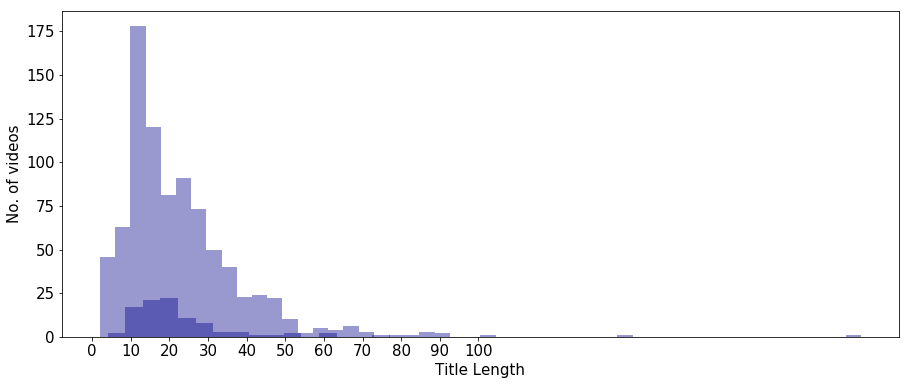

In [44]:
df["title_length"] = df["title"].apply(lambda x: len(x))
df_winners["title_length"] = df_winners["title"].apply(lambda x: len(x))

fig, ax = plt.subplots()
ax = sns.distplot(df["title_length"], color = 'darkblue', kde=False, rug=False, ax=ax);
ax = sns.distplot(df_winners["title_length"], color = 'darkblue', kde=False, rug=False, ax=ax);
ax.set(xlabel="Title Length", ylabel="No. of videos", xticks=range(0, 110, 10));

In [45]:
df[(df['title_length'] > 10) & (df['title_length'] < 30)]['title_length'].count() / df['title_length'].count() * 100

61.22209165687427

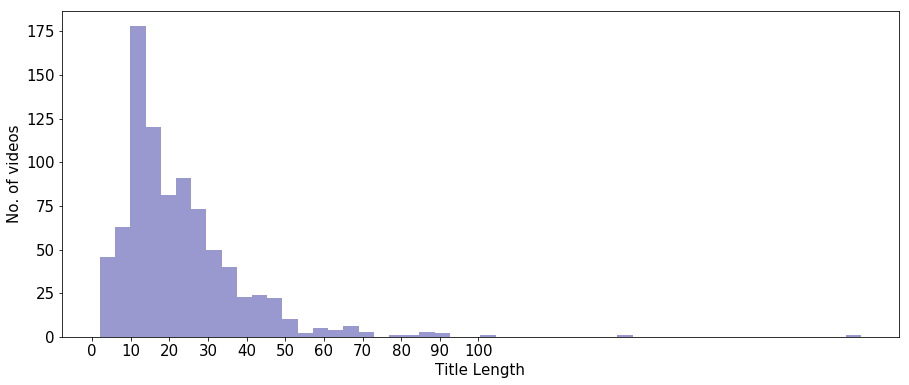

In [46]:
df["title_length"] = df["title"].apply(lambda x: len(x))

fig, ax = plt.subplots()
ax = sns.distplot(df["title_length"], color = 'darkblue', kde=False, rug=False, ax=ax);
ax.set(xlabel="Title Length", ylabel="No. of videos", xticks=range(0, 110, 10));

['Year', 'Height', 'Width', 'Title Length']


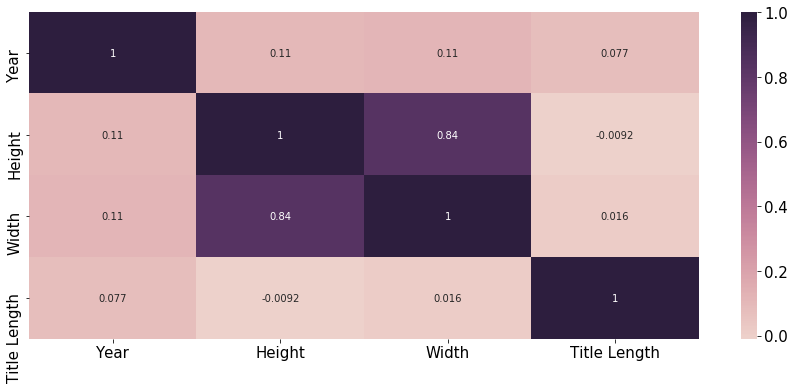

In [47]:
cor_labels = [x.replace('_', ' ').title() for x in list(df.select_dtypes(include=['number', 'bool']).columns.values)]

print(cor_labels)

fig, ax = plt.subplots()
ax = sns.heatmap(df.corr(), annot=True, xticklabels=cor_labels, yticklabels=cor_labels, cmap=sns.cubehelix_palette(as_cmap=True), ax=ax)

[Text(0,0.5,'Width'), Text(0.5,0,'Height')]

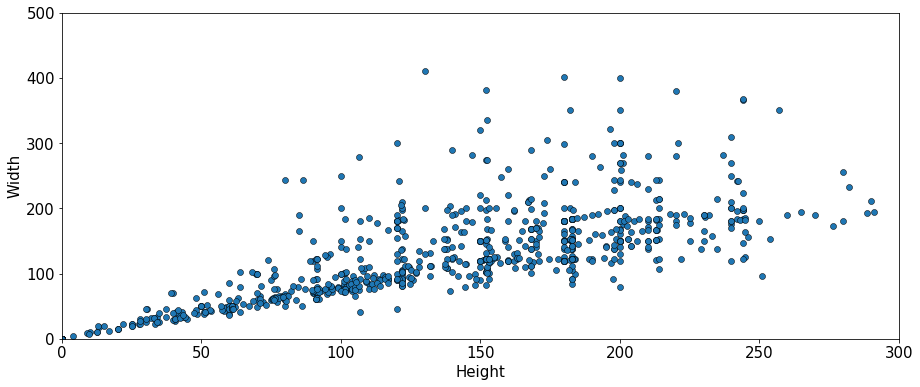

In [49]:
title_words = list(df["title"].apply(lambda x: x.split()))
title_words = [x for y in title_words for x in y]
Counter(title_words).most_common(10)

[('of', 114),
 ('The', 64),
 ('the', 64),
 ('and', 61),
 ('Portrait', 50),
 ('portrait', 48),
 ('a', 45),
 ('Self-portrait', 40),
 ('with', 36),
 ('in', 34)]

In [50]:
title_words = list(df[df["description"].notnull()]["description"].apply(lambda x: x.split()))
title_words = [x for y in title_words for x in y]
Counter(title_words).most_common(10)

[('the', 8978),
 ('in', 6589),
 ('and', 6572),
 ('of', 5619),
 ('a', 5429),
 ('to', 3564),
 ('is', 2635),
 ('was', 1942),
 ('I', 1940),
 ('has', 1735)]

(-0.5, 1199.5, 499.5, -0.5)

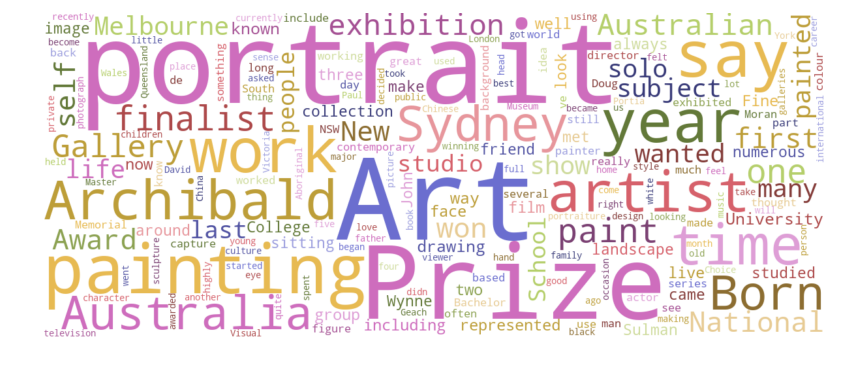

In [51]:
word_cloud = WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         colormap="tab20b").generate(" ".join(title_words))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")

### A bit of image analysis

As part of this analysis, I would like to see if we can extract any useful information about the artwork it self. We know that as part of the Archibald Prize set of rules, the artwork must be a portrait so I dont believe there is any need to implement neural networks to recognise objects in the artworks.

However it would be intresting to see the variety of colours that the contestants use in their artwork.

One way to extract colours from an image is using K-Means clustering. K-means clustering algorithm is an unsupervised algorithm and that is often used in image segmentation to cluster into K groups. I will not go much into the detail of the algorithm but one thing to note that it does require you to specify the number of clusters.

As you can see, pre-choosing the K clusters can be an issue in this analysis as different artworks can have different number of dominant colours. To address this, I will be using the Elbow Method to determine the optimum number of clusters for each image before choosing the final K cluster.

In progress - COMING SOON


In [52]:
import urllib

In [55]:
def download_artworks(i):
    urllib.request.urlretrieve(i["artlink-href"], "input/artworks/"+i["web-scraper-order"]+".jpg")

In [56]:
df.apply(download_artworks, axis=1);

KeyboardInterrupt: 

In [54]:
df.head(1)

,artlink-href,competition,description,dimensions,item,item-href,medium,name,prize,title,web-scraper-order,web-scraper-start-url,year-text,year-text-href,year,height,width,title_length
327,https://media.artgallery.nsw.gov.au/collection...,Archibald Prize 1921,NaN,108 x 104 cm,W B McInnes\n\n \t\tDesbrowe An...,https://www.artgallery.nsw.gov.au/prizes/archi...,oil on canvas,W B McInnes,Winner: Archibald Prize 1921,Desbrowe Annear,1538561150-1,https://www.artgallery.nsw.gov.au/prizes/archi...,Archibald 1921 finalists\n\t\t\n\t\t \n ...,https://www.artgallery.nsw.gov.au/prizes/archi...,1921,108.0,104.0,15
